In [1]:
library(RColorBrewer)
coul <- brewer.pal(8, "Set3") 

# Estimación GUM

Se definen las variables de entrada como las que se obtienen de la Hoja de Cálculo SK-fecha-10XX:
- $d$ es la división de escala de la balanza, siendo esta de $10\textrm{ kg}$.
- $L_{\textrm{exc}}$ es la carga utilizada en la prueba de excentricidad.
- $m_c$ es un vector que contiene las masas convencionales de los patrones.
- $U_{\textrm{exp}}$ es un vector con las incertidumbres expandidas de las masas patrón.
- $\textrm{EMP}$ es un vector con los errores máximos permitidos de cada una de las masas patrón, se define como: $$\textrm{EMP}=\sum_{i=1}^n\textrm{EMP}_i$$ Con $i$ la masa patrón.
- $I_s$ es un vector con las indicaciones reportadas por el operador en la prueba de error de indicación.
- $\textrm{Rep}$ es un vector con las indicaciones reportadas por el operador en la prueba de repetibilidad.
- $I_{exc,1}$ es un vector con las indicaciones reportadas por el operador en el sentido 1 de la prueba de excentricidad.
- $I_{exc,2}$ es un vector con las indicaciones reportadas por el operador en el sentido 2 de la prueba de excentricidad.
- $dif_{\textrm{máx}}$ es la máxima diferencia que se puede obtener en la prueba de excentricidad.
- $error$ es el error de indicación que se calcula como la diferencia entre la indicación y el valor de la masa convencional patrón.

In [2]:
d=0.0001
L_exc=100.000140
m_c=c(0.000997,0.019992,0.100012,0.499984,1.000031,10.00001,50.000177,100.00002,199.99998,310.00001)
U_exp=c(0.000012,0.000012,0.000016,0.000022,0.000026,0.00005,0.000079,0.00014,0.00027,0.000046)
EMP=c(0.00002,0.00003,0.00005,0.00008,0.0001,0.00020,0.0003,0.0005,0.001,0.0017)
Is=c(0.0010,0.0200,0.1000,0.5000,1.0000,10.0000,50.0000,100.0000,200.0000,310.0005)
Rep50=c(150.0000,150.0000,150.0000,150.0000,150.0000)
Rep100=c(310.0000,310.0000,310.0000,310.0000,310.0000)
I_exc=c(200.0000,200.0003,200.0003,200.0003,200.0003,200.0000)
dif_max=max(abs(I_exc[2:5]-mean(I_exc[1],I_exc[6])))
error=Is-m_c

Se calculan las incertidumbres estándar por empuje del aire, masas patrón, resolución, repetibilidad, excentricidad y deriva de los patrones.
- $u_{empj}$ es la incertidumbre por empuje del aire, en kilogramos, y se calcula como: $$u_{empj}=0.00000156\cdot m_c$$
- $m_c$ es la masa convencional del patrón.
- $u_{mc}$ es la incertidumbre estándar de los patrónes y se obtiene de dividir la incertidumbre expandida entre el factor de cobertura $k=2$.
- $u_{res}$ es la incertidumbre por resolución, se calcula igual para la resolución con carga y la resolución sin carga: $$u_{res}=\frac{d}{\sqrt{12}}$$
- $u_{rep}$ es la incertidumbre estándar por repetibilidad y se calcula como la desviación estándar de las indicaciones obtenidas de la prueba de repetibilidad.
- $u_{exc}$ es la incertidumbre estándar por excentricidad y se calcula como: $$u_{exc}=\frac{dif_{\textrm{máx}}\cdot I_s}{\sqrt{12}L_{exc}}$$
- $u_{der}$ es la incertidumbre por deriva de las pesas patrón y se calcula como: $$u_{der}=\frac{\sum_{i=1}^nEMP_i}{3\sqrt{3}}$$

In [3]:
u_empj=m_c*0.00000156
u_mc=U_exp/2
u_res=d/sqrt(12)
u_rep=max(sd(Rep50),sd(Rep100))
u_der=EMP/sqrt(3)/3

In [4]:
EMP

[1] 0.00002 0.00003 0.00005 0.00008 0.00010 0.00020 0.00030 0.00050 0.00100
[10] 0.00170

In [5]:
u_exc=dif_max*Is/L_exc/sqrt(12)

La incertidumbre estándar combinada se calcula como:
$$u_c=\sqrt{u_{exc}^2+2\cdot u_{res}^2+u_{mc}^2+u_{rep}^2+u_{der}^2+u_{empj}^2}$$

In [6]:
u_c=sqrt(u_mc**2+u_rep**2+2*u_res**2+u_der**2+u_exc**2+u_empj**2)

La incertidumbre expandida de cada punto de calibración se calcula como: $$U=2\cdot u_c$$

In [7]:
U=2*u_c

In [8]:
U

[1] 8.288502e-05 8.333070e-05 8.540003e-05 9.001110e-05 9.400470e-05
 [6] 1.279298e-04 2.409920e-04 4.366322e-04 8.585397e-04 1.288684e-03

### Gráficas de pesos de incertidumbre por cada punto de calibración

In [9]:
resumen=array(c(rep(u_res,10),rep(u_res,10),u_der,u_mc,u_empj,rep(u_rep,10),u_exc,u_c),dim=c(10,8))
fuentes=c("Resolución con carga","Resolución sin carga","Deriva de patrones","Patrones","Empuje del aire","Repetibilidad","Excentricidad","Incertidumbre combinada")

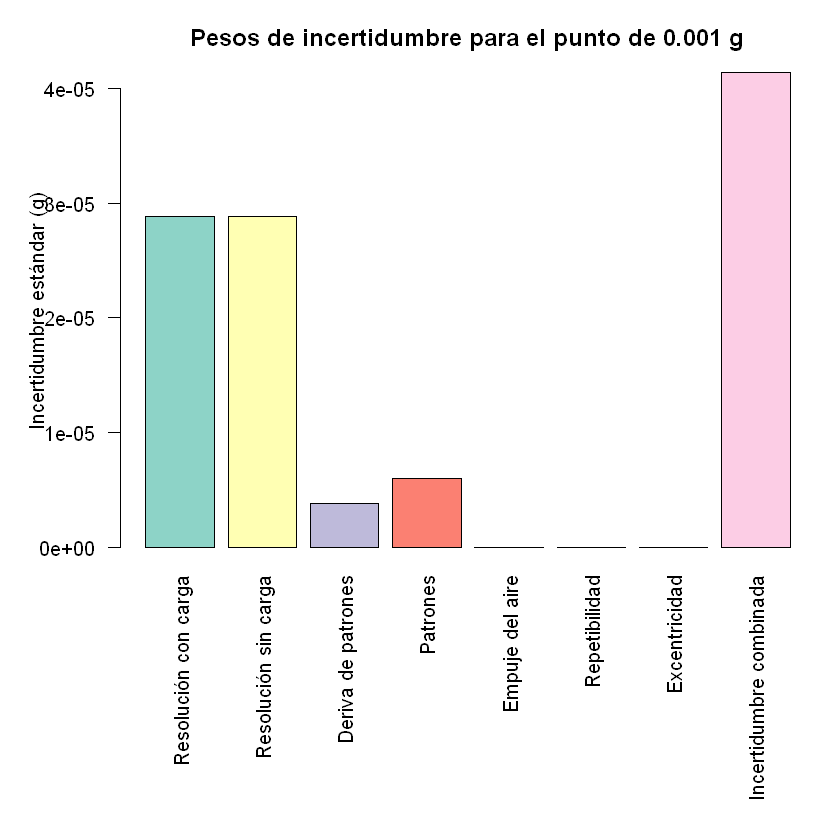

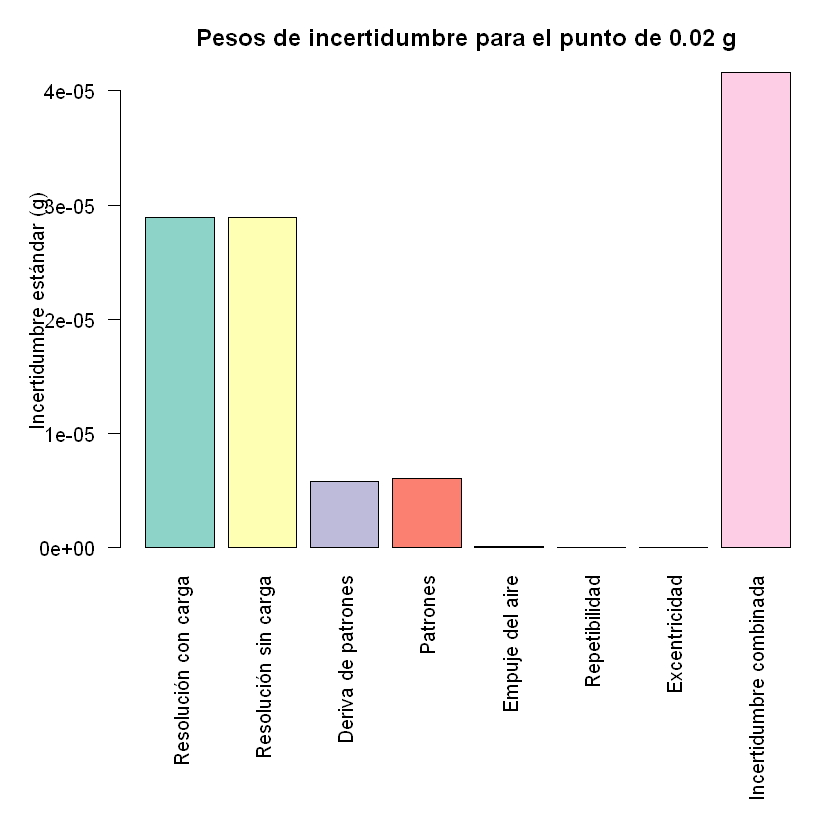

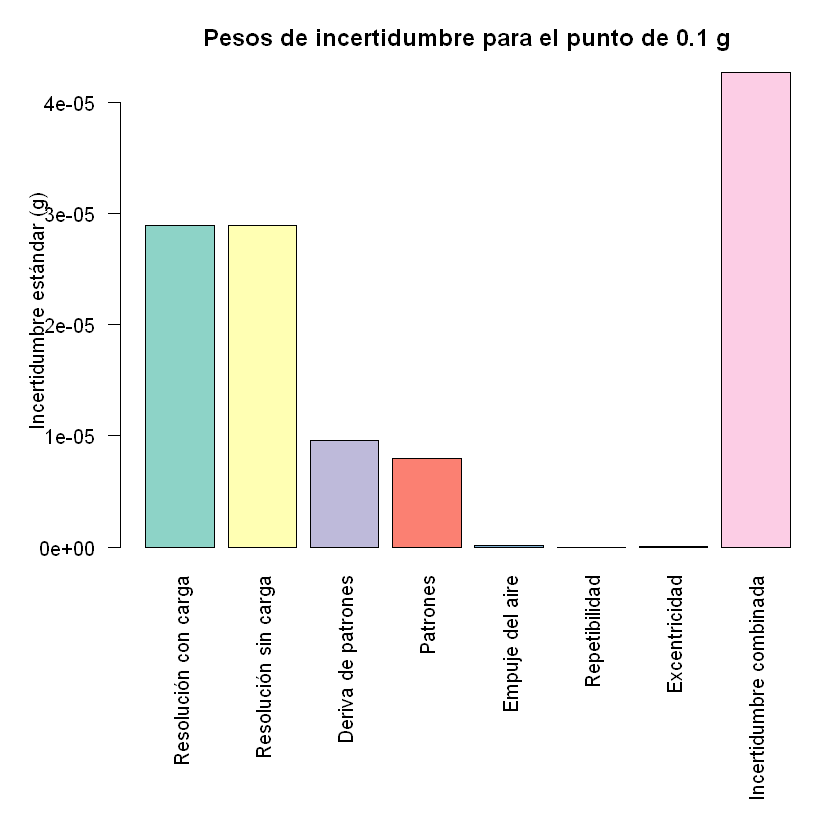

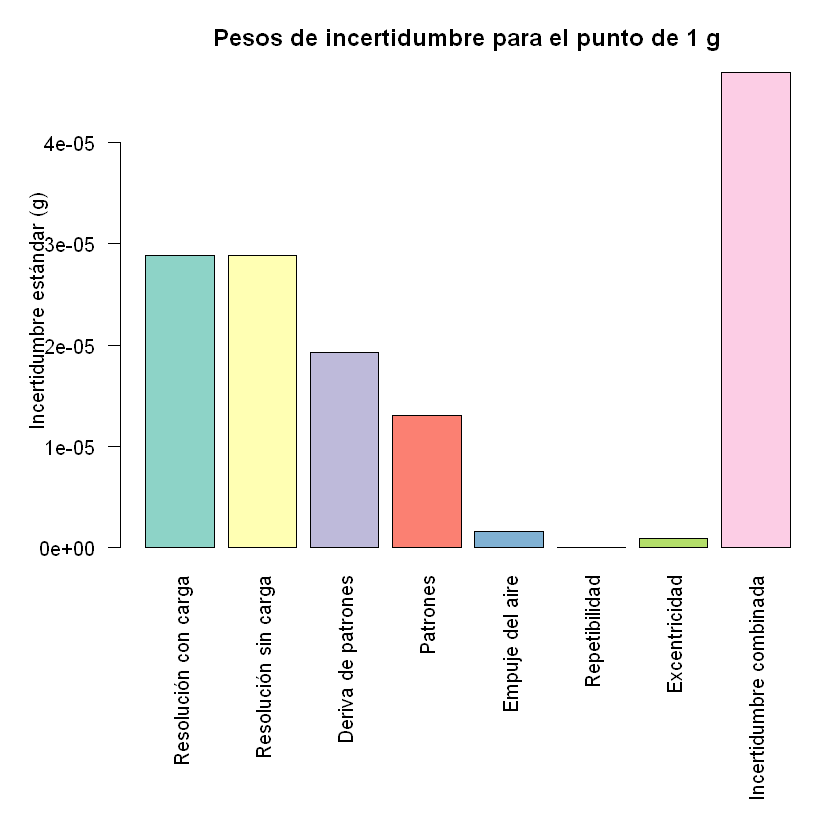

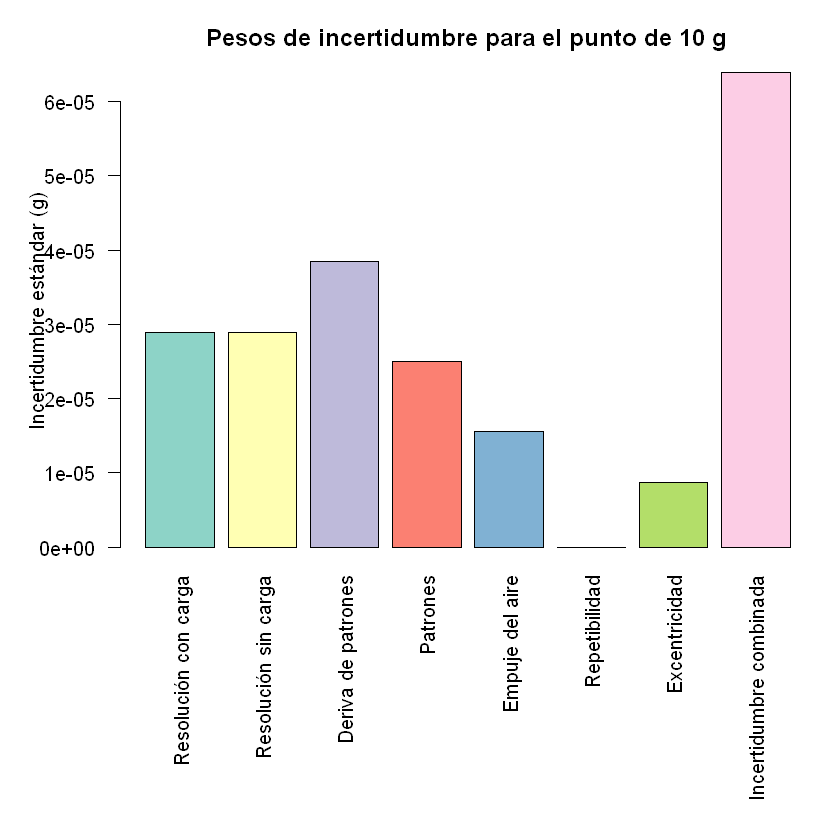

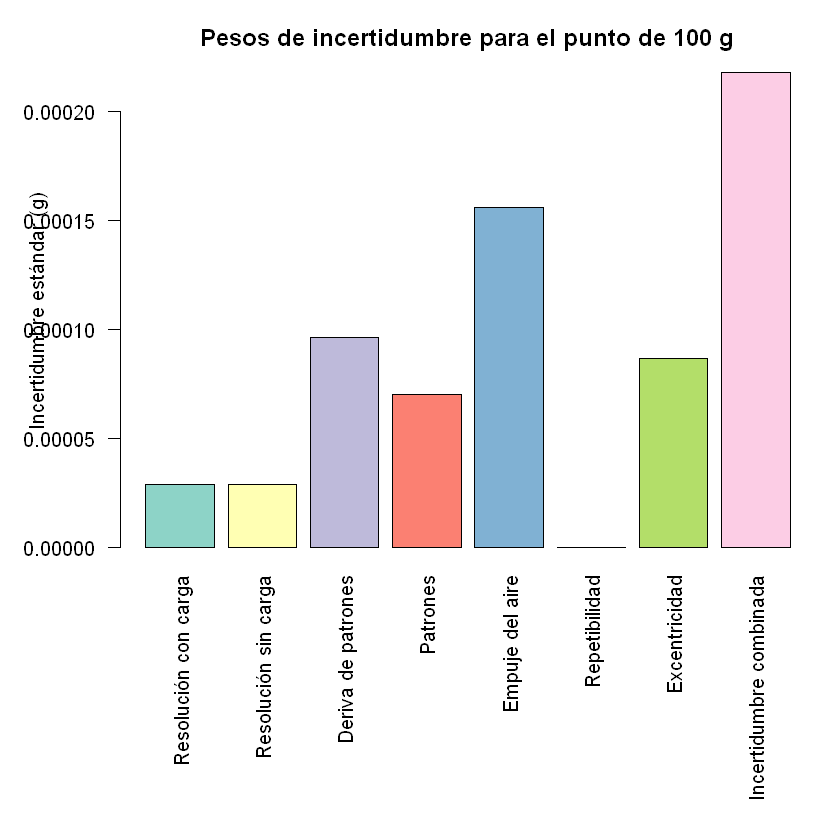

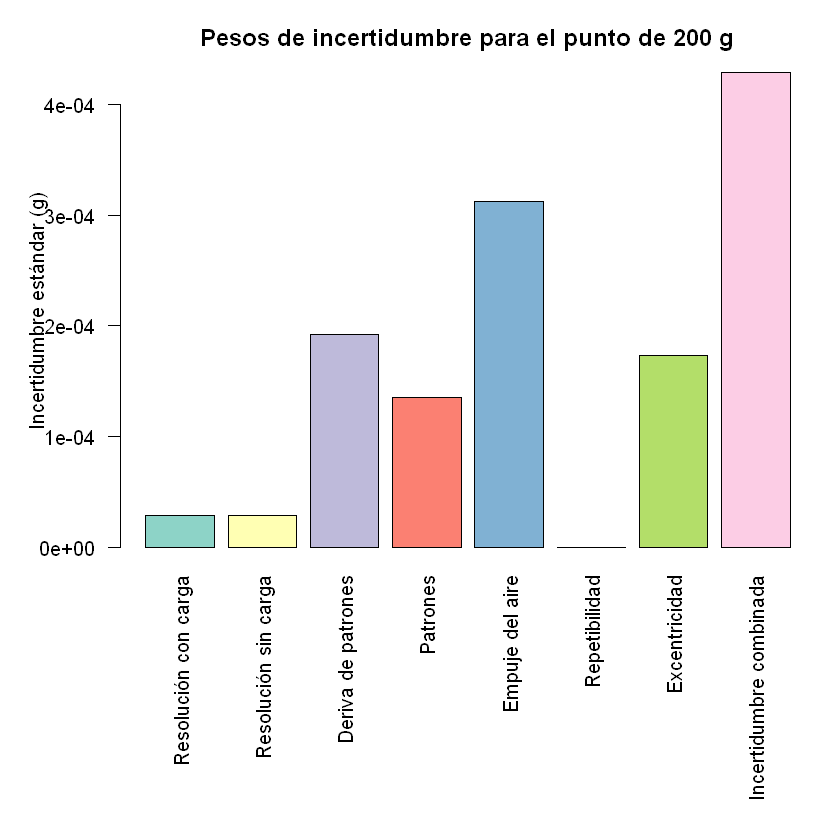

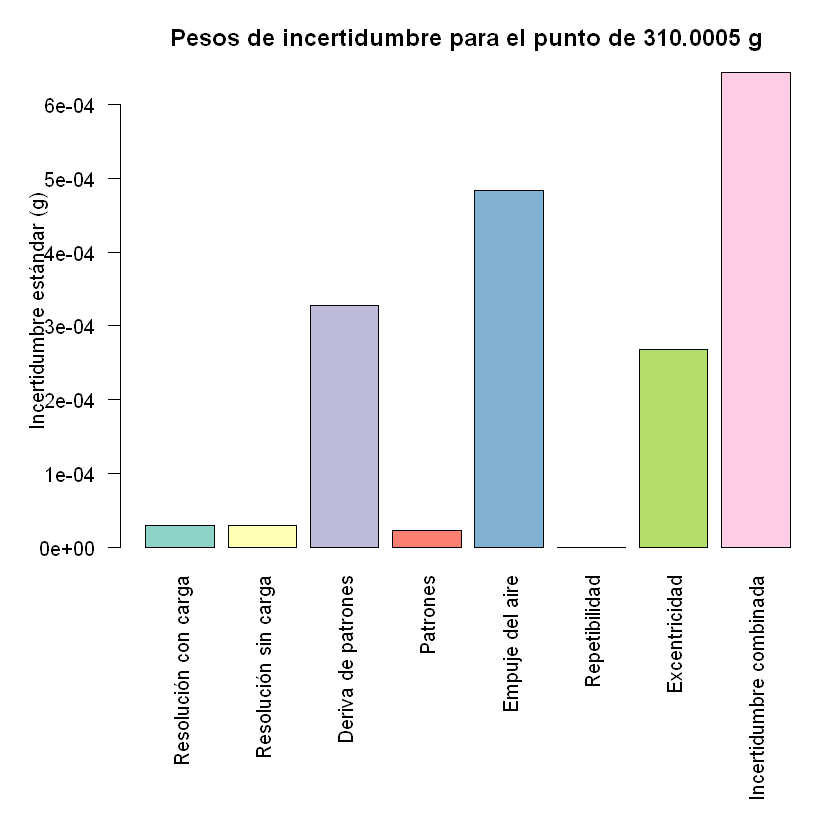

In [10]:
for (i in 1:10){
    par(mar=c(12,5,3,1))
    barplot(resumen[i,],names.arg=fuentes,las=2,col=coul, ylab="Incertidumbre estándar (g)",main=paste("Pesos de incertidumbre para el punto de",toString(Is[i]),"g",sep=" "))
    }

# Con Monte Carlo

Se utiliza el método de Monte Carlo para la estimación de la incertidumbre siguiendo el suplemento 101 de la GUM. Se utiliza un muestreo de un millón de números pseudoaleatorios con las funciones ```rnorm``` y ```runif```.

## Indicaciones con patrones

In [11]:
N=10**6
d=0.0001
L_exc=100.000140
m_c=array(c(0.000997,0.019992,0.100012,0.499984,1.000031,10.00001,50.000177,100.00002,199.99998,310.00001),dim=c(10,1))
Is=c(0.0010,0.0200,0.1000,0.5000,1.0000,10.0000,50.0000,100.0000,200.0000,310.0005)
U_exp=array(c(0.000012,0.000012,0.000016,0.000022,0.000026,0.00005,0.000079,0.00014,0.00027,0.000046),dim=c(10,1))
EMP=array(c(0.00002,0.00003,0.00005,0.00008,0.0001,0.00020,0.0003,0.0005,0.001,0.0017),dim=c(10,1))
Rep50=c(150.0000,150.0000,150.0000,150.0000,150.0000)
Rep100=c(310.0000,310.0000,310.0000,310.0000,310.0000)
I_exc=c(200.0000,200.0003,200.0003,200.0003,200.0003,200.0000)
dif_max=max(abs(I_exc[2:5]-mean(I_exc[1],I_exc[6])))
error=Is-m_c

Las incertidumbres por resolución siguen una distribución uniforme que va de $$\left[-\frac{d}{2},\quad\frac{d}{2}\right]$$

Donde:
- $d$ es la división de escala de la balanza.

In [12]:
u_res=array(dim=c(10,N),runif(10*N,-d/2,d/2))

In [13]:
u_res0=array(dim=c(10,N),runif(10*N,-d/2,d/2))

La incertidumbre por excentricidad sigue una distribución uniforme que se encuentra entre $$\left[\frac{-\Delta I_{\textrm{máx}}\cdot I}{2L_{\textrm{exc}}},\quad\frac{\Delta I_{\textrm{máx}}\cdot I}{2L_{\textrm{exc}}}\right]$$

Donde:
- $\Delta I_{\textrm{máx}}$ es la diferencia máxima calculada de la prueba de excentricidad.
- $I$ es la indicación de la balanza.
- $L_{\textrm{exc}}$ es la carga usada en la prueba de excentricidad.

In [14]:
u_exc=array(dim=c(10,N),runif(10*N,-dif_max*Is/L_exc/2,dif_max*Is/L_exc/2))

La incertidumbre por deriva de los patrones sigue una distribución uniforme que se encuentra entre $$\left[\frac{-\textrm{EMP}}{3},\quad\frac{\textrm{EMP}}{3}\right]$$

Donde:
- $\textrm{EMP}$ es el error máximo permitido de las pesas utilizadas.

In [15]:
u_der=array(dim=c(10,N),runif(10*N,-EMP/3,EMP/3))

La incertidumbre por repetibilidad sigue una distribución normal de media $0$ y desviación estándar igual a la obtenida de la prueba de repetibilidad.

In [16]:
u_rep=array(dim=c(10,N),rnorm(10*N,mean=0,sd=max(sd(Rep50),sd(Rep100))))

La incertidumbre por empuje del aire sigue una distribución uniforme delimitada por $$\left[\frac{-1.56\sqrt{3}\cdot m_c}{1\times10^6},\quad\frac{1.56\sqrt{3}\cdot m_c}{1\times10^6}\right]$$

Donde:
- $m_c$ es la masa convencional de los patrones.

In [17]:
u_empj=array(dim=c(10,N),runif(10*N,-sqrt(3)*m_c*0.00000156,sqrt(3)*m_c*0.00000156))

La incertidumbre de las masas patrón sigue una distribución normal con media $0$ y desviación estándar igual a $U/k$ con $U$ la incertidumbre expandida y $k=2$ el factor de covertura.

In [18]:
u_mc=array(dim=c(10,N),rnorm(10*N,mean=0,sd=U_exp/2))

Se realiza la convolución de las funciones de distribución de las distintas fuentes de incertidumbre.

In [19]:
cal=rep(error,N)+u_mc+u_empj+u_res0+u_res+u_exc+u_der+u_rep

In [20]:
resumen=matrix(0,10,12)
for (i in 1:10){
    resumen[i,1]=Is[i]
    resumen[i,2]=round(mean(cal[i,]),6)
    resumen[i,3]=round(sd(u_exc[i,]),6)
    resumen[i,4]=round(sd(u_rep[i,]),6)
    resumen[i,5]=round(sd(u_der[i,]),6)
    resumen[i,6]=round(sd(u_mc[i,]),6)
    resumen[i,7]=round(sd(u_empj[i,]),6)
    resumen[i,8]=round(sd(u_res[i,]),6)
    resumen[i,9]=round(sd(u_res0[i,]),6)
    resumen[i,10]=round(sd(cal[i,]),6)
    resumen[i,11]=resumen[i,3]^2/resumen[i,10]^2*100
    resumen[i,12]=round(2*sd(cal[i,]),6)
    }

In [21]:
df=data.frame(resumen)

In [22]:
colnames(df)=c("Indicación","Error de indicación (kg)","Excentricidad (kg)","Repetibilidad (kg)","Deriva (kg)","Patrones (kg)","Empuje (kg)","Resolución (kg)","Resolución sin carga (kg)","Incertidumbre estándar (kg)","Aporte (%)","Incertidumbre expandida (kg)")
df

Indicación Error de indicación (kg) Excentricidad (kg) Repetibilidad (kg)
1    0.0010    0.000003                0.000000           0                 
2    0.0200    0.000008                0.000000           0                 
3    0.1000   -0.000012                0.000000           0                 
4    0.5000    0.000016                0.000000           0                 
5    1.0000   -0.000031                0.000001           0                 
6   10.0000   -0.000010                0.000009           0                 
7   50.0000   -0.000177                0.000043           0                 
8  100.0000   -0.000020                0.000087           0                 
9  200.0000    0.000019                0.000173           0                 
10 310.0005    0.000491                0.000268           0                 
   Deriva (kg) Patrones (kg) Empuje (kg) Resolución (kg)
1  0.000004    0.000006      0.000000    2.9e-05        
2  0.000006    0.000006      0.000000    2.9e-05        
3  0.000010    0.000008      0.000000    2.9e-05        
4  0.000015    0.000011      0.000001    2.9e-05        
5  0.000019    0.000013      0.000002    2.9e-05        
6  0.000038    0.000025      0.000016    2.9e-05        
7  0.000058    0.000040      0.000078    2.9e-05        
8  0.000096    0.000070      0.000156    2.9e-05        
9  0.000192    0.000135      0.000312    2.9e-05        
10 0.000327    0.000023      0.000483    2.9e-05        
   Resolución sin carga (kg) Incertidumbre estándar (kg) Aporte (%) 
1  2.9e-05                   0.000041                     0.00000000
2  2.9e-05                   0.000042                     0.00000000
3  2.9e-05                   0.000043                     0.00000000
4  2.9e-05                   0.000045                     0.00000000
5  2.9e-05                   0.000047                     0.04526935
6  2.9e-05                   0.000064                     1.97753906
7  2.9e-05                   0.000120                    12.84027778
8  2.9e-05                   0.000218                    15.92668967
9  2.9e-05                   0.000429                    16.26213724
10 2.9e-05                   0.000644                    17.31800471
   Incertidumbre expandida (kg)
1  0.000083                    
2  0.000083                    
3  0.000085                    
4  0.000090                    
5  0.000094                    
6  0.000128                    
7  0.000241                    
8  0.000436                    
9  0.000859                    
10 0.001289